Purpose of this analysis is to identify the exchange rates whose distributions of training, validation and test sets are same for each future.
Kolmogorov-Smirnov test is used to compare the distributions.

# IMPORT LIBRARIES

In [1]:
import MetaTrader5 as mt5

import pandas as pd

import pytz

from datetime import datetime

from sklearn.model_selection import train_test_split

import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import entropy
from scipy.stats import ks_2samp

# CONFIG

In [2]:
pd.set_option('display.float_format', '{:.5f}'.format)

In [3]:
gc_s_PATH_TO_FILTER = 'Stocks\\United States\\Software'

In [4]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2022, 3, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2022, 7, 1, tzinfo=gc_o_TIME_ZONE)

In [5]:
gc_a_FEATURES_TO_ANALYZE = ['close','open', 'high', 'low','real_volume','return']

In [6]:
gc_f_TRAINING_RATIO = 0.60
gc_f_VALIDATION_RATIO = 0.20
gc_f_TEST_RATIO = 0.20

# UDFS

In [7]:
def aFilterSymbolsByPath(p_tplSymbols, p_sPathToFilter):
    aToReturn = []
    for tplS in p_tplSymbols:
        if p_sPathToFilter in tplS.path:
            aToReturn.append(tplS)
            
    return aToReturn

In [8]:
def dfFetchSampleDataFromMt(p_sSymbolName):
    aOhlSample = mt5.copy_rates_range(
        p_sSymbolName,
        mt5.TIMEFRAME_M15,
        gc_dt_FROM, 
        gc_dt_TO
    )

    dfToReturn = pd.DataFrame(aOhlSample)
    if 'time' in list(dfToReturn.columns):
        dfToReturn.set_index('time', inplace = True)
    else:
        return dfFetchSampleDataFromMt(p_sSymbolName)
    
    return dfToReturn

In [9]:
def dfCalculateReturn(p_dfToSplit):
    p_dfToSplit['return'] =  (p_dfToSplit['close']-p_dfToSplit['open'])/p_dfToSplit['open']
    return p_dfToSplit

In [10]:
def ixSplitDateset(p_dfToSplit):

    ixAll = p_dfToSplit.index

    ixTrain, ixTest = train_test_split(
        ixAll,
        test_size=1-gc_f_TRAINING_RATIO,
        shuffle=False)

    ixValidation, ixTest = train_test_split(
        ixTest,
        test_size=gc_f_TEST_RATIO/(gc_f_TEST_RATIO + gc_f_VALIDATION_RATIO),
        shuffle=False)
    
    
    return ixTrain, ixValidation, ixTest

In [11]:
def fTestDifferenceOfDistributions(p_dfOhlcSample, p_sFeatureName ,p_ixTrain, p_ixValidation, p_ixTest):
    # The null hypothesis is that the two distributions are identical
    # If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.
    fStatsTrainVal, fPValueTrainVal = ks_2samp(
        p_dfOhlcSample.loc[p_ixTrain, p_sFeatureName],
        p_dfOhlcSample.loc[p_ixValidation, p_sFeatureName]
    )
    
    fStatsTrainTest, fPValueTrainTest = ks_2samp(
        p_dfOhlcSample.loc[p_ixTrain, p_sFeatureName],
        p_dfOhlcSample.loc[p_ixTest, p_sFeatureName]
    )

    fStatsValTest, fPValueValTest = ks_2samp(
        p_dfOhlcSample.loc[p_ixValidation, p_sFeatureName],
        p_dfOhlcSample.loc[p_ixTest, p_sFeatureName]
    )
    
    
    
    return fStatsTrainVal, fPValueTrainVal, fStatsTrainTest, fPValueTrainTest, fStatsValTest, fPValueValTest


# MAIN

In [12]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
tplSymbols = mt5.symbols_get()
# tplSymbols = aFilterSymbolsByPath(tplSymbols, gc_s_PATH_TO_FILTER)

In [13]:
aColNames = [
    'Symbol Name',
    'Feature',
    'Train vs Validation',
    'Train vs Test',
    'Validation vs Test']
dfPValue = pd.DataFrame(columns =aColNames )
dfStats = pd.DataFrame(columns = aColNames)

for tplS in tplSymbols:
    sSymbolName = tplS.name
    dfOhlcSample = dfFetchSampleDataFromMt(sSymbolName)
    
    if len(dfOhlcSample) > 1000: #filter only the symbols that have more than specific amount of rows
        dfOhlcSample = dfCalculateReturn(dfOhlcSample)
        ixTrain, ixValidation, ixTest = ixSplitDateset(dfOhlcSample)
        
        for sFeatureName in gc_a_FEATURES_TO_ANALYZE:
            fStatsTrainVal, fPValueTrainVal, fStatsTrainTest, fPValueTrainTest, fStatsValTest, fPValueValTest = fTestDifferenceOfDistributions(
                dfOhlcSample, 
                sFeatureName ,
                ixTrain, 
                ixValidation, 
                ixTest)

            dfPValue = pd.concat(
                [
                dfPValue, 
                pd.DataFrame([[sSymbolName, sFeatureName, fPValueTrainVal,fPValueTrainTest, fPValueValTest]], columns = aColNames)
                ]
                , ignore_index=False
            )

            dfStats = pd.concat(
                [dfStats, 
                pd.DataFrame([[sSymbolName, sFeatureName, fStatsTrainVal,fStatsTrainTest, fStatsValTest ]], columns = aColNames)
                ]
                , ignore_index=False
            )

        
dfPValue.reset_index(drop= True, inplace = True)
dfStats.reset_index(drop= True, inplace = True)

In [14]:
dfPValue

,Symbol Name,Feature,Train vs Validation,Train vs Test,Validation vs Test
0,EURUSD,close,0.00000,0.00000,0.00000
1,EURUSD,open,0.00000,0.00000,0.00000
2,EURUSD,high,0.00000,0.00000,0.00000
3,EURUSD,low,0.00000,0.00000,0.00000
4,EURUSD,real_volume,0.00034,0.00001,0.00000
...,...,...,...,...,...
13477,#SBean_U22,open,0.00000,0.00000,0.00000
13478,#SBean_U22,high,0.00000,0.00000,0.00000
13479,#SBean_U22,low,0.00000,0.00000,0.00000
13480,#SBean_U22,real_volume,1.00000,1.00000,1.00000


In [15]:
dfPValue.to_csv('Results\\train_val_test_dist_analysis_p_val.csv', sep = ';', index = False)
dfStats.to_csv('Results\\train_val_test_dist_analysis_stats.csv', sep = ';', index = False)

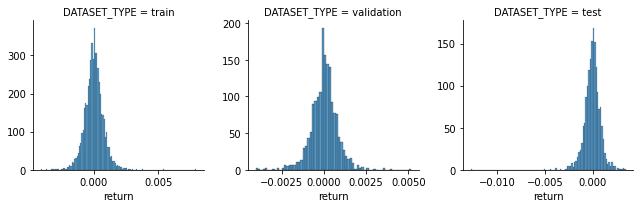

In [16]:
dfOhlcSample = dfFetchSampleDataFromMt('AUDCHF')
ixTrain, ixValidation, ixTest = ixSplitDateset(dfOhlcSample)
dfOhlcSample = dfCalculateReturn(dfOhlcSample)

dfOhlcSample.loc[ixTrain, 'DATASET_TYPE'] = 'train' 
dfOhlcSample.loc[ixValidation, 'DATASET_TYPE'] = 'validation' 
dfOhlcSample.loc[ixTest, 'DATASET_TYPE'] = 'test' 

oFig = sns.FacetGrid(data = dfOhlcSample , col = 'DATASET_TYPE', col_wrap = 3, sharex = False, sharey = False )
oFig.map(sns.histplot, 'return')